<a href="https://colab.research.google.com/github/sayan0506/Tensorflow-in-practice-specialization/blob/master/SUNSPOT_time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# this is used to visualize the time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # adds grid to the time series plot
    plt.grid(True)

In [3]:
# downloading the dataset from kaggle
# syntax is !wget --no-check-certificate \url \-O /destination where to download
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-31 08:44:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.7.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-12-31 08:44:09 (165 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



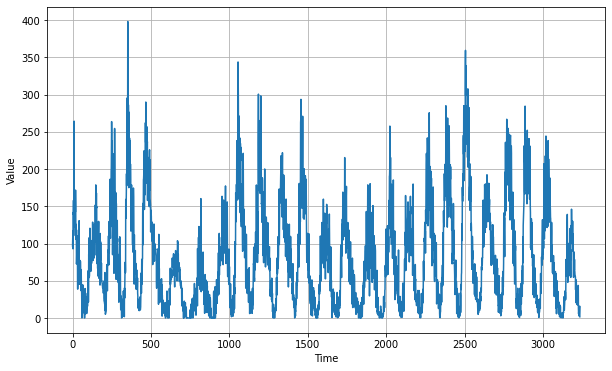

In [4]:
import csv
import pandas as pd

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  #df = pd.read_csv(csvfile, delimiter=',')
  #print(df)
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for column in reader:
    # column 0 corresponds to serial number of the datapoint or timestamp
    # whereas column 2 is the value at that timestep
    sunspots.append(float(column[2]))
    time_step.append(int(column[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

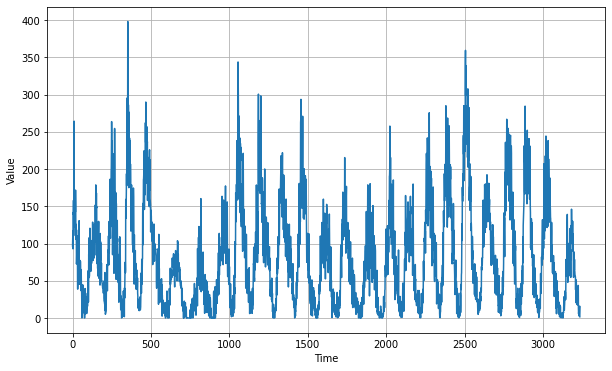

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
# splitting the data into train and validation set
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 16
shuffle_buffer_size = 1000


In [7]:
# creating the window
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # expanding the dimension around the last index (-1)
    # shape = (m, window_length), thus we add another dimension around window_length
    series = tf.expand_dims(series, axis=-1)
    print(series.shape)
    # converting the series to tensor
    ds = tf.data.Dataset.from_tensor_slices(series)
    # we are building windows from the datasets by dropping the remainders, so that all windows are of same length
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # flattens the windowed dataset
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffling the buffer, or shuffle buffer stores a certain amount of datapoints inside the buffer
    # which helps to speed up the training, else it has to load individual datapoints to gpu, instead it loads the chunk of data inside the buffer
    ds = ds.shuffle(shuffle_buffer)
    # maps the buffered dataset to input and output, 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
# we put window size 132
# as we have 11 years of cycle, and each data point corresponds to 12 months
window_size = 132
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
                                     #, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


(3000, 1)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
90/90 [==============================] - 4s 15ms/step - loss: 85.9465 - mae: 86.4442
Epoch 2/100
90/90 [==============================] - 1s 15ms/step - loss: 86.0833 - mae: 86.5810
Epoch 3/100
90/90 [==============================] - 1s 14ms/step - loss: 85.8466 - mae: 86.3439
Epoch 4/100
90/90 [==============================] - 1s 14ms/step - loss: 85.6287 - mae: 86.1262
Epoch 5/100
90/90 [==============================] - 1s 14ms/step - loss: 85.0336 - mae: 85.5308
Epoch 6/100
90/90 [==============================] - 1s 15ms/step - loss: 85.6784 - mae: 86.1756
Epoch 7/100
90/90 [==============================] - 1s 14ms/step - loss: 85.9920 - mae: 86.4892
Epoch 8/100
90/90 [==============================] - 1s 15ms/step - loss: 85.2136 - mae: 85.7106
Epoch 9/100
90/90 [==============================] - 1s 14ms/step - loss: 85.1156 - mae: 85.6127
Epoch 10/100
90

(1e-08, 0.0001, 0.0, 60.0)

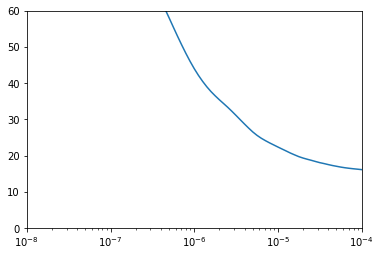

In [24]:
# from the decaying learning rate or learning rate scheduler plot,
# we can see 1e-04 is the optimal learning rate for the ADAM optimizer
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [122]:
# clears the previous training session, so that, current session is not being interrupted by the previous one
# so that internal variables in the present session is randomly initialized newly
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
batch_size = 16
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.Adam(lr=1e-4)
                                     #, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

(3000, 1)
Epoch 1/150
30/30 [==============================] - 5s 22ms/step - loss: 56.4035 - mae: 56.9004
Epoch 2/150
30/30 [==============================] - 1s 19ms/step - loss: 31.1876 - mae: 31.6825
Epoch 3/150
30/30 [==============================] - 1s 19ms/step - loss: 26.7162 - mae: 27.2104
Epoch 4/150
30/30 [==============================] - 1s 19ms/step - loss: 24.3180 - mae: 24.8110
Epoch 5/150
30/30 [==============================] - 1s 20ms/step - loss: 23.0700 - mae: 23.5625
Epoch 6/150
30/30 [==============================] - 1s 19ms/step - loss: 22.5527 - mae: 23.0448
Epoch 7/150
30/30 [==============================] - 1s 20ms/step - loss: 21.8168 - mae: 22.3083
Epoch 8/150
30/30 [==============================] - 1s 19ms/step - loss: 21.2087 - mae: 21.7005
Epoch 9/150
30/30 [==============================] - 1s 19ms/step - loss: 20.7898 - mae: 21.2809
Epoch 10/150
30/30 [==============================] - 1s 20ms/step - loss: 20.9117 - mae: 21.4034
Epoch 11/150
30/30 

In [123]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

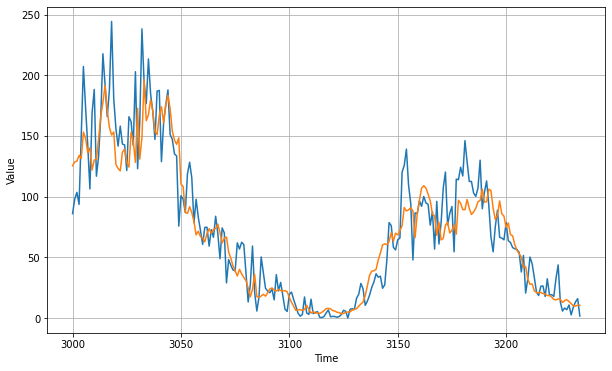

In [124]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [125]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.558429

ValueError: ignored

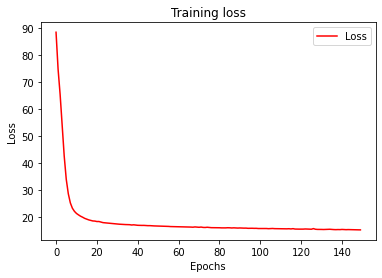

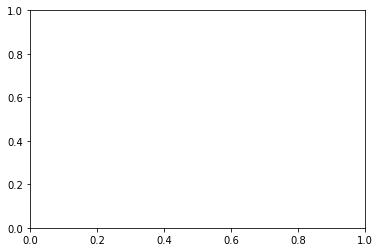

In [51]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[189.90692   201.73523   195.16821   176.61748   160.45683   147.23537
 102.007065   79.80938    67.96037    96.14046   107.1042     56.443424
 140.00542   167.42197   163.5265    100.092064   86.57879    84.34755
  72.24117    46.461315   31.693014   54.758896  108.89174   126.53118
 153.26154   182.04703   229.25465   255.48688   277.61264   272.68134
 268.3986    244.71411   204.49837   111.864975   98.44899    76.619255
 100.75364   123.520996  143.70494   167.98491   176.23007   192.04411
 195.05496   186.9491    187.4377    170.31226   167.49153   183.27884
 187.3695    181.8315    173.07738   163.14334   144.35623   138.26059
 140.70885   135.89186   110.95924   101.0393     91.621185   78.502594
  77.20649    82.89499    81.77284    90.80789    80.01983    72.046486
  65.17363    67.16391    59.344803   52.69022    50.688316   56.98074
  36.86218    20.86995    16.466322   20.465166   25.86309    25.598246
  21.237951   20.285225   24.947824   38.107975   44.585487   33.182056
